In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import scipy.stats
import pylab

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [37]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [38]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head(-1)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0
...,...,...,...,...,...,...,...,...
2019-10-08,9366.5,9403.5,9347.5,9378.5,16.0,9376.5,134774.0,144640.0
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

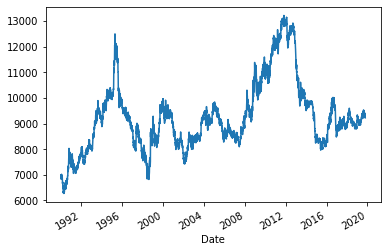

In [39]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot();

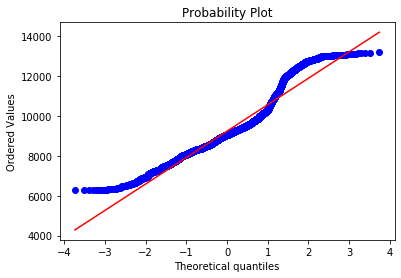

In [41]:
# Probability Plot used to infer the distribution
scipy.stats.probplot(yen_futures.Settle,plot=pylab);

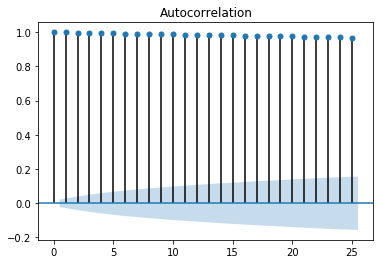

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(yen_futures.Settle, lags=25);

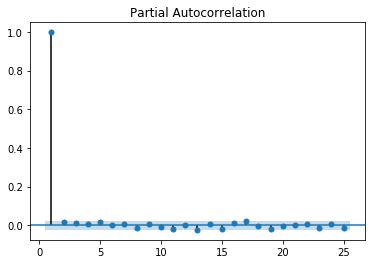

In [6]:
import statsmodels as sm
sm.graphics.tsaplots.plot_pacf(yen_futures.Settle, lags=25, zero=False);

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [7]:
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [8]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df = pd.DataFrame()
df['price']=yen_futures.Settle
df['noise']=settle_noise
df['trend']=settle_trend
df.head()

,price,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


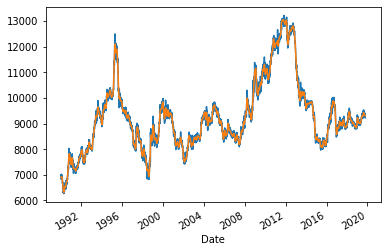

In [9]:
# Plot the Settle Price vs. the Trend
df.price.plot();
df.trend.plot();

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

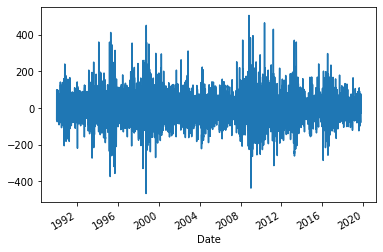

In [10]:
# Plot the Settle Noise
df.noise.plot();

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [11]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head(-1)

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275
...,...
2019-10-08,0.170931
2019-10-09,-0.410601
2019-10-10,-0.369458


In [12]:
# Import ARMA model
from statsmodels.tsa.arima_model import ARMA

In [13]:
# Create ARMA model
model = ARMA(returns.values, order=(2,1))

In [14]:
# Fit model to data
results = model.fit()

In [15]:
# Model summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 12 Aug 2020   AIC                          15798.142
Time:                        12:31:57   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2948      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3335           +0.0000j            3.3335            0.5000
AR.2         -157.1373           +0.0000j          157.1373            0.5000
MA.1           -3.3923           +0.0000j            3.3923            0.5000
-----------------------------------------------------------------------------
"""

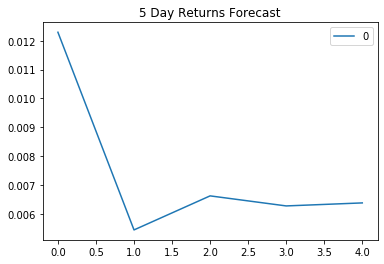

In [16]:
# Plot of 5 day returns forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast");

Question: Based on the p-value, is the model a good fit?

Answer:

### *Based upon the p-value, the model is NOT a good fit. If we presume a confidence interval of 95%, the p-value is well above 5% so we can safely say the results fail to reject the null hypothesis.*

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(df.price, order=(5, 1, 1))

C:\Users\erics\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\erics\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [18]:
# Fit the model
results=model.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 12 Aug 2020   AIC                          83905.238
Time:                        12:32:04   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3160      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.price     0.2823      0.699      0.404      0.686      -1.088       1.652
ar.L2.D.price     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.price    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.price    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.price    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.price    -0.2973      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8919           -1.3785j            2.3408           -0.1002
AR.2            1.8919           +1.3785j            2.3408            0.1002
AR.3           -2.2705           -3.0204j            3.7786           -0.3526
AR.4           -2.2705           +3.0204j            3.7786            0.3526
AR.5          -11.0852           -0.0000j           11.0852           -0.5000
MA.1            3.3635           +0.0000j            3.3635            0.0000
-----------------------------------------------------------------------------
"""

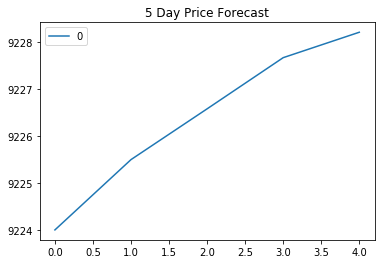

In [20]:
# Plot of the 5 day price forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast");

What does the model forecast will happen to the Japanese Yen in the near term?

#### *The model predicts that the USD / JPY futures exahcange rate will rise to 9,228.*

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [21]:
from arch import arch_model

In [22]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [23]:
# Model fit
garch_results = model.fit(disp="off")

In [24]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Wed, Aug 12 2020   Df Residuals:                     7511
Time:                        12:32:17   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

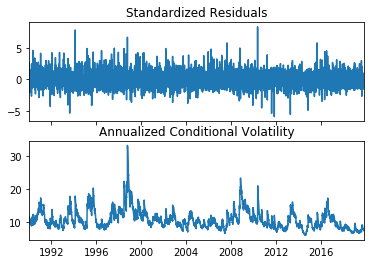

In [28]:
fig = garch_results.plot(annualize='D')

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [30]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [31]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [32]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


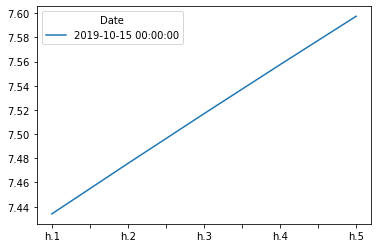

In [34]:
# Plot the final forecast
final.plot();

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

### *The GARCH volatility model returned solid results. As such, I have a higher degree of faith in the volatility prediction vs. the return prediction (further above). However, given the expected rise in volatility over the forecast period, I would still be cautious at purchasing the Yen futures contract outright.* 

### *In this case, if implied volatility (observed through option pricing) is equal or higher than forecasted by our GARCH model, I might consider writing a put option at spot or slightly below. Again this presumes the implied volatility of the option I would write is equal or higher than the expected volatility predicted by our GARCH model. Quite simply, the higher the implied volatility (i.e. risk), the higher the higher the option premium I would receive.*

### *Playing the strategy out, if the price falls below the strike price, I would acquire the futures contract. However, my acquisition price would be the strike less the premium received. If the price rises I would keep the premium collected from the put option, & I could then write another put option when the initial expires, continuing to generate income as the Yen appreciates in value without investing the capital to acquire.*